In [45]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.io import fits
import glob
plt.rcParams["image.origin"]='lower'

# Brightness Profiles

In [46]:
#get data files
files = glob.glob('/Users/blewis/Desktop/grad-school/Research/GPI-disks/20190427_H_Pol-TME/*mJy*.fits')
print(files)

['/Users/blewis/Desktop/grad-school/Research/GPI-disks/20190427_H_Pol-TME/S20190427S0339_podc_distorcorr_rstokesdc_sm2_stpol13-15_quadsub_mJy_arcsec-2.fits', '/Users/blewis/Desktop/grad-school/Research/GPI-disks/20190427_H_Pol-TME/S20190427S0339_podc_distorcorr_rstokesdc_sm1_stpol13-15_quadsub_mJy_arcsec-2.fits', '/Users/blewis/Desktop/grad-school/Research/GPI-disks/20190427_H_Pol-TME/S20190427S0339_podc_distorcorr_rstokesdc_sm0_stpol13-15_quadsub_mJy_arcsec-2.fits']


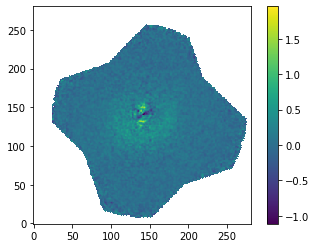

In [55]:
import matplotlib.patches as mpatches
data = fits.getdata('/Users/blewis/Desktop/grad-school/Research/GPI-disks/20190427_H_Pol-TME/S20190427S0339_podc_distorcorr_rstokesdc_sm2_stpol13-15_quadsub_mJy_arcsec-2.fits')
I = data[0,:,:] #total intensity
Q = data[1,:,:] #what we care about
plt.imshow(Q)
plt.colorbar()
plt.show()
U = data[2,:,:] #noise / nothing

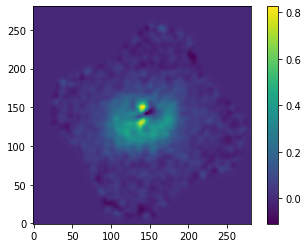

In [56]:
##smooth image
import scipy.ndimage
Q[np.isnan(Q)]=0
Q_sm = scipy.ndimage.gaussian_filter(Q, sigma=(3, 3), order=0)
plt.imshow(Q_sm)
plt.colorbar()
plt.show()

(0, 281)

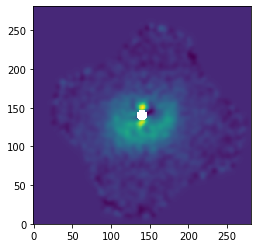

In [57]:
import numpy.ma as ma
r = np.zeros((281,281))
for i in np.arange(0,281):
    for j in np.arange(0,281):
        r[i,j] = np.sqrt((i-140)**2 + (j-140)**2)
masked = ma.masked_where(r<7, Q_sm, copy=True)
plt.imshow(masked)
plt.ylim(0,281)

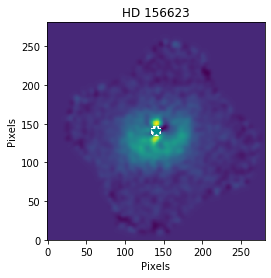

In [69]:
#let's make a nice plot of the disk
plt.imshow(masked)
plt.plot(140,140,marker='*',color='darkcyan',markersize=10)
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.title('HD 156623')
plt.ylim(0,281)
plt.savefig('../plots/hd156623.png')
plt.show()

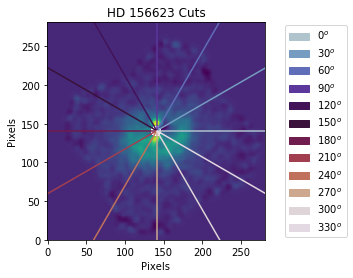

In [58]:
##make figure to show angles used
from matplotlib import collections

plt.imshow(masked)
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.title('HD 156623 Cuts')

line_list=[]
cmap = plt.cm.get_cmap('twilight')
colors=[]
labels=[]
i=1
##these angles reflect what scipy.rotate will take! NOT actual position angle (offset from PA by 90 deg)
thetas = [0,30,60,90,120,150,180,210,240,270,300,330]
for angle in thetas:
    x0 = 141
    y0 = 141
    x1 = (300*np.sin(np.deg2rad(angle)+(np.pi/2)))+141
    #print(x1)
    y1 = (300*np.cos(-np.deg2rad(angle)+(np.pi/2)))+141
    coords = [(x0,y0),(x1,y1)]
    line_list.append(coords)
    colors.append(cmap(i*45))
    labels.append('{}$^o$'.format(angle))
    i=i+1
    
import matplotlib.patches as mpatches
handles=[]
for p in range(len(colors)):
    patch = mpatches.Patch(color=colors[p], label=labels[p])
    handles.append(patch)

plt.imshow(masked)
#print(line_list)
plt.ylim(0,281)
collection_1_2=collections.LineCollection(line_list, color=colors)
ax = plt.gca()
ax.add_collection(collection_1_2)
plt.legend(handles=handles,loc='center right', bbox_to_anchor=[1.4,0.5])
plt.savefig('../plots/hd156623-legend.png')
plt.show()

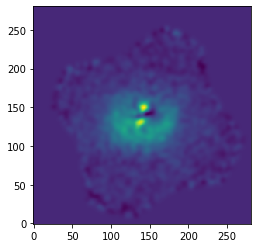

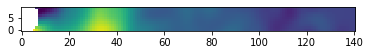

(0, 80)

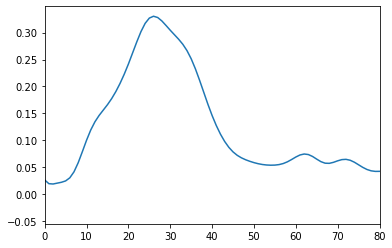

In [59]:
##test
rotated_im = scipy.ndimage.rotate(Q_sm,angle=10,reshape=False)
plt.imshow(rotated_im)
plt.show()

plt.imshow(masked[135:145,140:])
plt.show()

plt.plot(range(0,281-147),np.average(masked[137:147,147:],axis=0))
plt.xlim(0,80)

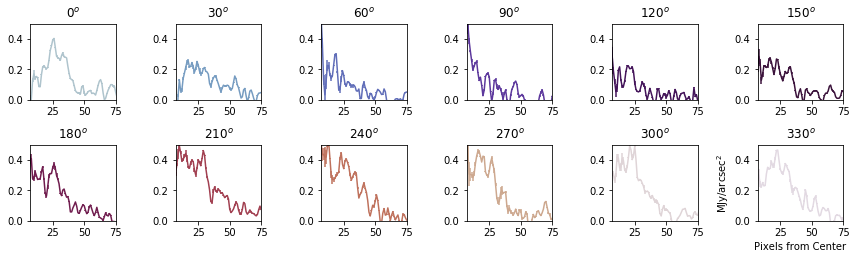

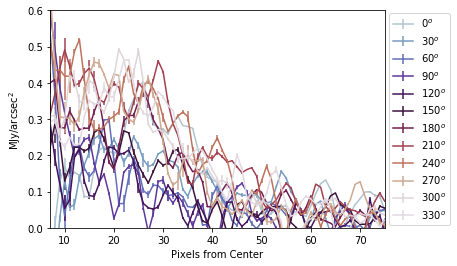

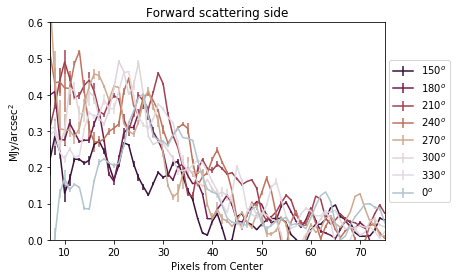

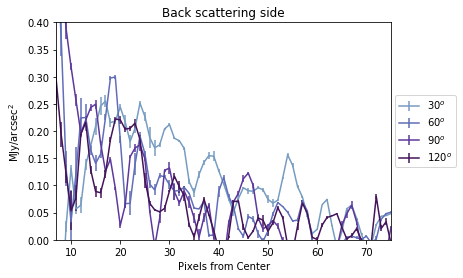

In [75]:
#repeat the following over multiple angles:
theta=0
thetas=[]
profiles=[]
w=10
h=10
fig=plt.figure(figsize=(12, 10))
ax=[]
colors=[]
variances=[]
columns = 6
rows = 6
i=1
while theta<360:
    
    #rotate image and take sums
    rotated_im = scipy.ndimage.rotate(Q,angle=theta,reshape=False)
    rotated_im = ma.masked_where(r<7, rotated_im, copy=True)
    profile = np.average(rotated_im[137:147,147:],axis=0)
    variance = np.var(rotated_im[137:147,147:],axis=0)
    cmap = plt.cm.get_cmap('twilight')
    if theta%30==0:
        ax.append(fig.add_subplot(rows, columns, i))
        pix = np.asarray(range(0,281-147))
        plt.errorbar(pix,profile,yerr=variance,color=cmap(i*45))
        ax[-1].set_title('{}$^o$'.format(theta))
        ax[-1].set_xlim(7,75)
        ax[-1].set_ylim(0,0.5)
        #ax[-1].set_xlabel('Pixels from Center')
        colors.append(cmap(i*45))
        profiles.append(profile)
        variances.append(variance)
        i=i+1   
        thetas.append(theta)
    theta=theta+5
    
plt.xlabel('Pixels from Center')
plt.ylabel('MJy/arcsec$^2$')
#fig.text(0.5, 0.04, 'Pixels from Center', ha='center')
#fig.text(0.04, 0.5, 'MJy/arcsec$^2$', va='center', rotation='vertical')
plt.tight_layout()
plt.savefig('../plots/rbp_Q_pix.png')
plt.show()

#saving these angles for clarity
np.save("brightness-profile-angles",thetas)

#make plots of all
cmap = plt.cm.get_cmap('twilight')
for i in range(0,len(thetas)):
    plt.errorbar(pix,profiles[i],yerr=variances[i],label='{}$^o$'.format(thetas[i]),color=colors[i])
plt.xlim(7,75)
plt.ylim(0,0.6)
plt.xlabel('Pixels from Center')
plt.ylabel('MJy/arcsec$^2$')
plt.legend(loc='center right', bbox_to_anchor=[1.21,0.5])
plt.savefig('../plots/rbp_all_Q_pix.png',bbox_inches='tight')
plt.show()

#forward scattering
for i in np.insert(0,0,range(5,len(thetas))):
    plt.errorbar(pix,profiles[i],yerr=variances[i],label='{}$^o$'.format(thetas[i]),color=colors[i])
plt.xlim(7,75)
plt.ylim(0,0.6)
plt.xlabel('Pixels from Center')
plt.ylabel('MJy/arcsec$^2$')
plt.title('Forward scattering side')
plt.legend(loc='center right', bbox_to_anchor=[1.21,0.5])
plt.savefig('../plots/rbp_forward_singleplot_Q_pix.png',bbox_inches='tight')
plt.show()

for i in range(1,5):
    plt.errorbar(pix,profiles[i],yerr=variances[i],label='{}$^o$'.format(thetas[i]),color=colors[i])
plt.xlim(7,75)
plt.ylim(0,0.4)
plt.xlabel('Pixels from Center')
plt.title('Back scattering side')
plt.ylabel('MJy/arcsec$^2$')
plt.legend(loc='center right', bbox_to_anchor=[1.21,0.5])
plt.savefig('../plots/rbp_back_singleplot_Q_pix.png',bbox_inches='tight')
plt.show()

In [76]:
np.save("brightness-profiles",profiles)
#12 angle slices x 134 pix

In [70]:
##would be useful to have these plots in AU!
pixels = np.asarray(range(0,281))
angles = pixels*14.2e-3 #plate scale in arcsec
separations = 111.75*206265*(angles*2e-5)

def pix_to_AU(pixval,ps,d):
    #pixval in # pixels, platescale in arcsec/pix and d in pc
    sep = d*206265*(pixval*ps*2e-5)
    return sep

def AU_to_pix(sep,ps,d):
    #pixval in # pixels, platescale in arcsec/pix and d in pc
    pixval=sep/(d*206265*(ps*2e-5))
    return pixval

d = 1/(8.9484e-3) ##distance from parallax
ps = 14.2e-3
print(pix_to_AU(10,ps,d))
print(AU_to_pix(12,ps,d))
print(AU_to_pix(180,ps,d))

65.46339010325869
1.8330856347451296
27.496284521176943


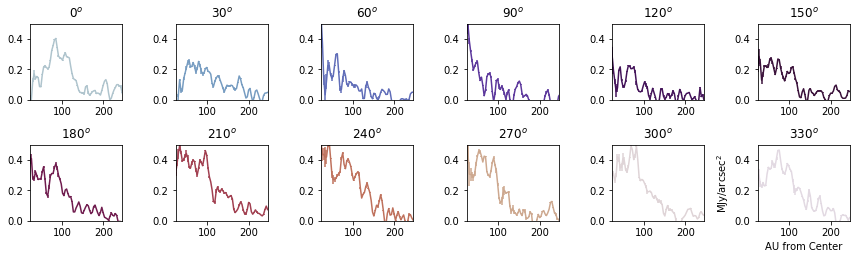

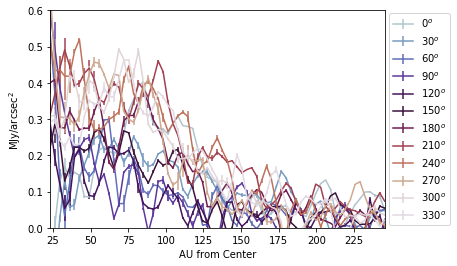

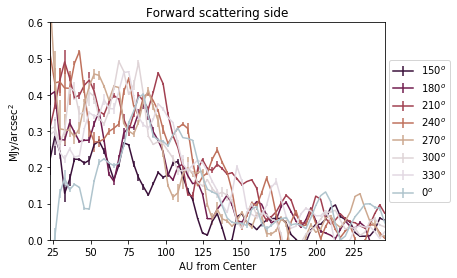

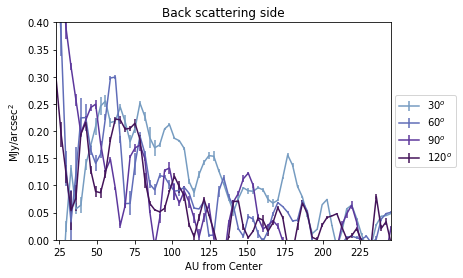

In [74]:
##do it all again in AU
#repeat the following over multiple angles:
theta=0
thetas=[]
profiles=[]
w=10
h=10
fig=plt.figure(figsize=(12, 10))
ax=[]
colors=[]
variances=[]
columns = 6
rows = 6
i=1
while theta<360:
    
    #rotate image and take sums
    rotated_im = scipy.ndimage.rotate(Q,angle=theta,reshape=False)
    rotated_im = ma.masked_where(r<7, rotated_im, copy=True)
    profile = np.average(rotated_im[137:147,147:],axis=0)
    variance = np.var(rotated_im[137:147,147:],axis=0)
    cmap = plt.cm.get_cmap('twilight')
    if theta%30==0:
        ax.append(fig.add_subplot(rows, columns, i))
        pix = np.asarray(range(0,281-147))
        AUs = pix_to_AU(pix,ps,d)/2
        plt.errorbar(AUs,profile,yerr=variance,color=cmap(i*45))
        ax[-1].set_title('{}$^o$'.format(theta))
        ax[-1].set_xlim(pix_to_AU(7,ps,d)/2,pix_to_AU(75,ps,d)/2)
        ax[-1].set_ylim(0,0.5)
        #ax[-1].set_xlabel('Pixels from Center')
        colors.append(cmap(i*45))
        profiles.append(profile)
        variances.append(variance)
        i=i+1   
        thetas.append(theta)
    theta=theta+5
    
plt.xlabel('AU from Center')
plt.ylabel('MJy/arcsec$^2$')
#fig.text(0.5, 0.04, 'Pixels from Center', ha='center')
#fig.text(0.04, 0.5, 'MJy/arcsec$^2$', va='center', rotation='vertical')
plt.tight_layout()
plt.savefig('../plots/rbp_Q_AU.png')
plt.show()

#make plots of all
cmap = plt.cm.get_cmap('twilight')
for i in range(0,len(thetas)):
    plt.errorbar(AUs,profiles[i],yerr=variances[i],label='{}$^o$'.format(thetas[i]),color=colors[i])
plt.xlim(pix_to_AU(7,ps,d)/2,pix_to_AU(75,ps,d)/2)
plt.ylim(0,0.6)
plt.xlabel('AU from Center')
plt.ylabel('MJy/arcsec$^2$')
plt.legend(loc='center right', bbox_to_anchor=[1.21,0.5])
plt.savefig('../plots/rbp_all_Q_AU.png',bbox_inches='tight')
plt.show()

#forward scattering
for i in np.insert(0,0,range(5,len(thetas))):
    plt.errorbar(AUs,profiles[i],yerr=variances[i],label='{}$^o$'.format(thetas[i]),color=colors[i])
plt.xlim(pix_to_AU(7,ps,d)/2,pix_to_AU(75,ps,d)/2)
plt.ylim(0,0.6)
plt.xlabel('AU from Center')
plt.ylabel('MJy/arcsec$^2$')
plt.title('Forward scattering side')
plt.legend(loc='center right', bbox_to_anchor=[1.21,0.5])
plt.savefig('../plots/rbp_forward_singleplot_Q_AU.png',bbox_inches='tight')
plt.show()

for i in range(1,5):
    plt.errorbar(AUs,profiles[i],yerr=variances[i],label='{}$^o$'.format(thetas[i]),color=colors[i])
plt.xlim(pix_to_AU(7,ps,d)/2,pix_to_AU(75,ps,d)/2)
plt.ylim(0,0.4)
plt.xlabel('AU from Center')
plt.title('Back scattering side')
plt.ylabel('MJy/arcsec$^2$')
plt.legend(loc='center right', bbox_to_anchor=[1.21,0.5])
plt.savefig('../plots/rbp_back_singleplot_Q_AU.png',bbox_inches='tight')
plt.show()

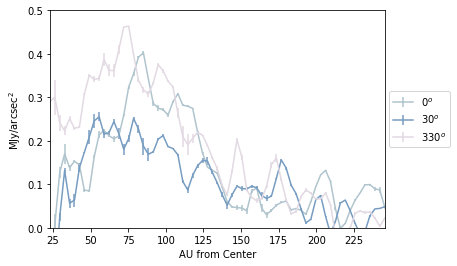

In [79]:
###What's going on around that strange hint of an inner hole?
for i in [0,1,-1]:
    plt.errorbar(AUs,profiles[i],yerr=variances[i],label='{}$^o$'.format(thetas[i]),color=colors[i])
plt.xlabel('AU from Center')
plt.ylabel('MJy/arcsec$^2$')
plt.legend(loc='center right', bbox_to_anchor=[1.21,0.5])
plt.xlim(pix_to_AU(7,ps,d)/2,pix_to_AU(75,ps,d)/2)
plt.ylim(0,0.5)
plt.savefig('../plots/rbp_hole_Q_AU.png',bbox_inches='tight')
plt.show()